The result paths need to be updated to the run the ML model.
Please delete the existing result folders when running the model.

In [1]:
# file paths
black_friday = 'data/BlackFriday.csv'
test_path="data/test.csv"
path="data/train.csv"
decision_tree_result = "data/result/Submission_dt"
decision_tree_train_split_result = "data/result/Submission_dt_tvs"
random_forest_result = "data/result/Submission_rf"

In [2]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats
from scipy.stats import sem, t
from scipy import mean


In [3]:
df = pd.read_csv('data/BlackFriday.csv')
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


The file contains below columns,
 
User_ID: Unique ID of a customer
Product_ID: Unique ID of a product
Gender: Gender of the customer. There are two values for this feature, viz. F, M.
Age: Age group of the customer. The age group has been divided into 0-17, 18-25, 26-35, 36-45, 46-50, 51-55 and 55+
Occupation: The occupation ID of the customer
City_Category: The city category viz. A, B, C
Stay_In_Current_City_Years: The customers stay in the current city
Marital_Status: Customers Marital status, It's a boolean value.
Product_Category_1: Product category 1
Product_Category_2: Product category 2
Product_Category_3: Product category 3
Purchase: Purchase amount for the given product by the given customer
 
Let's check if there are any missing values in the file.

In [4]:
print(df.isnull().any())

User_ID                       False
Product_ID                    False
Gender                        False
Age                           False
Occupation                    False
City_Category                 False
Stay_In_Current_City_Years    False
Marital_Status                False
Product_Category_1            False
Product_Category_2             True
Product_Category_3             True
Purchase                      False
dtype: bool


By looking at above result only Product_Category_2 and Product_Category_3 have null values. The mean and median values cannot be applied in this scenario. The best solution is fill them with non-existing category value. As the values for Product_Category_1 are integer, lets fill the null values with 0.

In [5]:
df.fillna(0,inplace=True)
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,0.0,0.0,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,0.0,0.0,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,0.0,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,0.0,0.0,7969


Now that we have a clean data, we can start analysing the file. 

The purchase behavior of a customer can be examined by the analysing the low level information of the customer such as Gender, Age, Occupation, length of stay in the city, marital status, occupation etc.


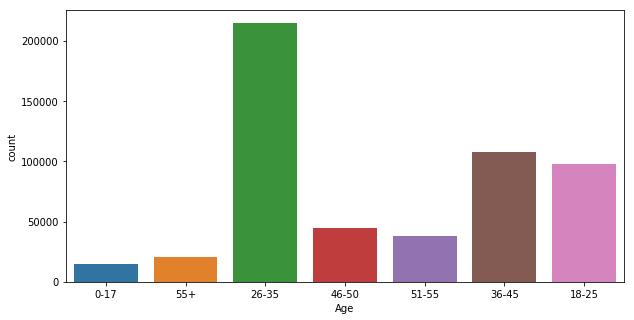

In [6]:
fig, axs = plt.subplots(figsize=(10,5))
sns.countplot(df['Age'])

By looking at the Age plot it looks like the customers with age group 26-35 purchased more than other age groups.

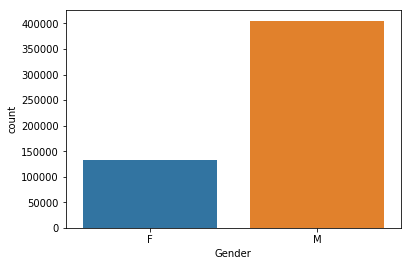

In [7]:
sns.countplot(df['Gender'])

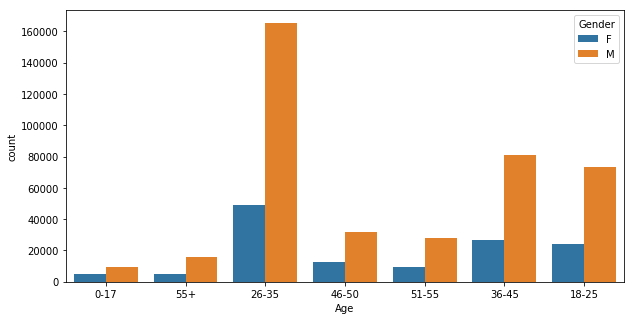

In [8]:
fig, axs = plt.subplots(figsize=(10,5))
sns.countplot(df['Age'],hue=df['Gender'])

The above graph indicates males purchased more products than females. It can also mean that even though females purchased the products, their male partners might have paid for it. Hence the purchase was registered under their name. We can test this theory by further analysing the data for marital status column.

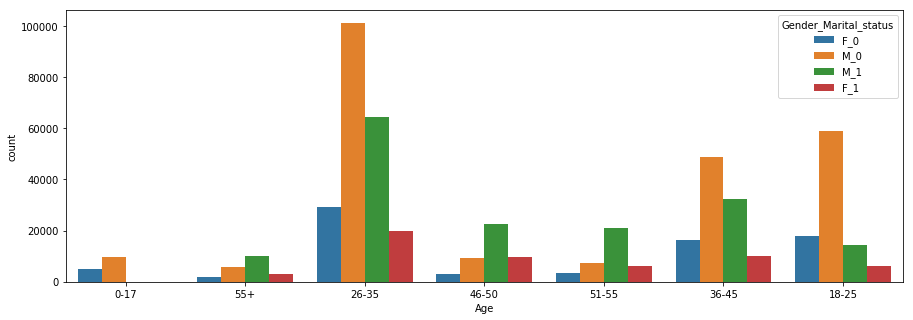

In [9]:
fig, axs = plt.subplots(figsize=(15,5))
df['Gender_Marital_status'] = df.apply(lambda x:'%s_%s' % (x['Gender'],x['Marital_Status']),axis=1)
sns.countplot(df['Age'],hue=df['Gender_Marital_status'])

As we see in all age group despite the marital status males are the highest purchasers. But this doesn't indicate that the males purchased the products for themselves and the current dataset doesn't have any information about that. Also as the product categories in the dataset are in integer values they don't have any information whether the product falls under faminine category. Hence we don't know for sure which gender is more likely to purchase more products.

The above graph also indicates that the unmarried people from ages 0 to 45 have purchased more than that of married people in those age groups. However from ages 46 and above the married people have purchased more. The reason behind it could be the married population is greater than unmarried population in 45+ age groups. 

Let's check the average amount spend by each gender

The userId is repeated in the file, because a user has purchased multiple products. Lets create a dataframe with columns userID, gender and their total purchase.

In [10]:
user_total_purchase = df.groupby(['User_ID', 'Gender'])[['Purchase']].sum().reset_index()
gender_average_purchase = user_total_purchase.groupby(['Gender'])['Purchase'].agg('mean').reset_index()
gender_average_purchase.head()

,Gender,Purchase
0,F,699054.034214
1,M,911963.161420


Below is the plot for average purchase for each gender.

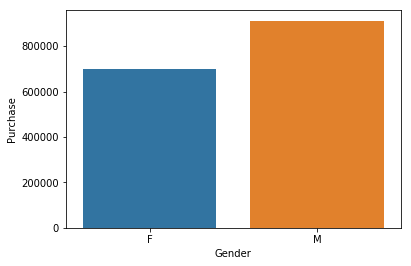

In [11]:
sns.barplot(x = 'Gender', y = 'Purchase', data = gender_average_purchase)

The above graph indicates that even though the number of purchases made by males are more than double than that of females, there is a only a small different between their average purchase amount.


Let's see which products have been purchased by each age group

In [12]:
age_total_purchase = df.groupby(['Age', 'Product_Category_1'])[['Purchase']].sum().reset_index()


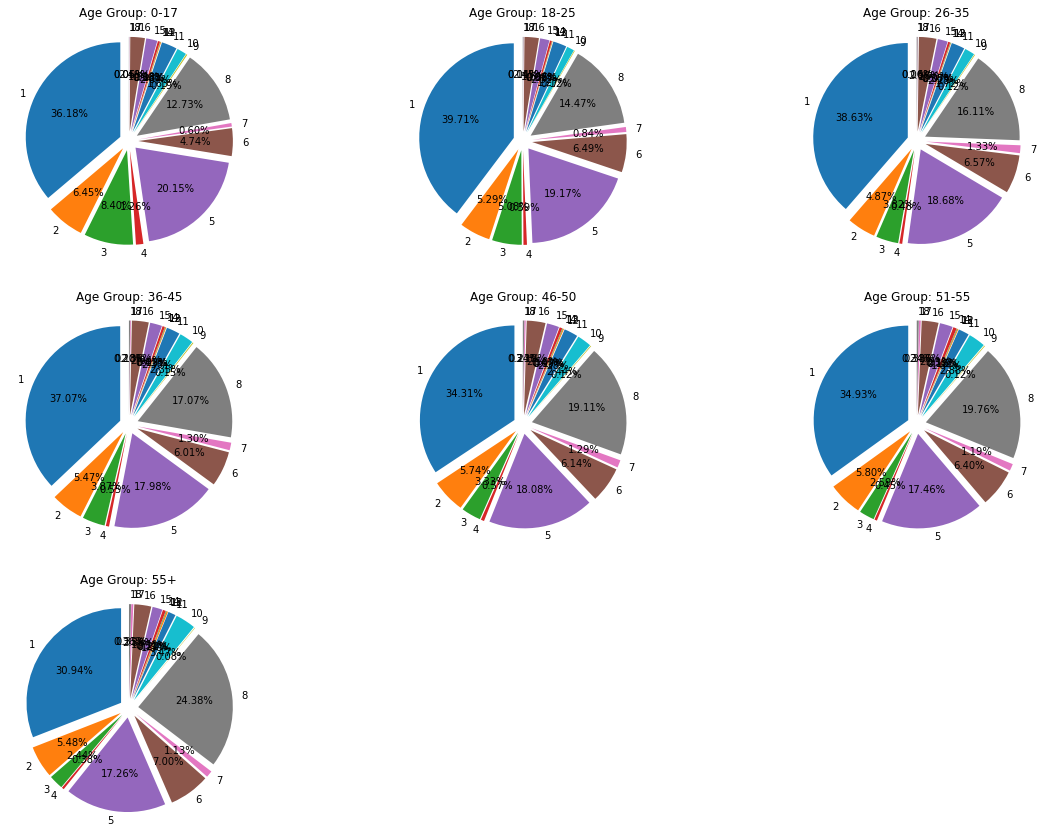

In [13]:
age_groups = age_total_purchase['Age'].unique()
plot_rows = len(age_groups)/2 + len(age_groups)%2

figure = plt.figure(figsize=(20,20))

i = 1
for age in age_groups:
    ax = figure.add_subplot(plot_rows, 3, i)
    category_purchase = age_total_purchase[age_total_purchase['Age'] == age]
    labels = category_purchase['Product_Category_1'].values
    total_purchase = category_purchase['Purchase'].values
    explode = [0.1 for i in range(len(total_purchase))]
    ax.pie(total_purchase, labels=labels, autopct='%.2f%%', explode = explode, startangle=90)
    plt.title("Age Group: "+age)
    i+=1



The above graph indicates that despite the age group Product Category 1 has been purchased more as compared to other categories. The distribution of total purchase of Product Category 1 by each Age group is similar. This graph can be used to recommend specific products for each age groups.


Now let's plot purchases for the city categories

In [14]:
city_total_purchase = df.groupby(['City_Category'])[['Purchase']].sum().reset_index()
city_total_purchase.head()

,City_Category,Purchase
0,A,1295668797
1,B,2083431612
2,C,1638567969


In [15]:
city_purchase_count = df.groupby(['City_Category']).size().reset_index(name='counts')
city_purchase_count.head()

,City_Category,counts
0,A,144638
1,B,226493
2,C,166446


([<matplotlib.patches.Wedge at 0x1a19cae6a0>,
 [Text(-0.8229598156883979, 0.7298884447380424, 'A'),
  Text(-0.13981115167211647, -1.0910787514511116, 'B'),
  Text(0.9090550691229756, 0.6193697452264053, 'C')],
 [Text(-0.4488871721936715, 0.398120969857114, '26.91%'),
  Text(-0.07626062818479079, -0.595133864427879, '42.13%'),
  Text(0.495848219521623, 0.33783804285076646, '30.96%')])

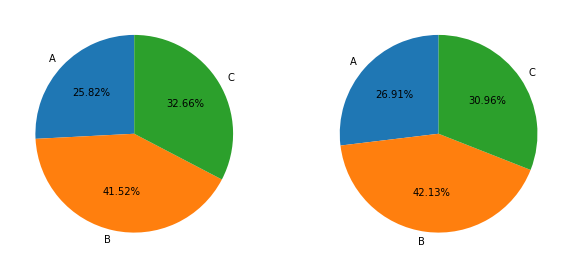

In [16]:
figure = plt.figure(figsize=(10,10))
ax1 = figure.add_subplot(2, 2, 1)
ax2 = figure.add_subplot(2, 2, 2)

labels1 = city_total_purchase['City_Category'].values
total_purchase = city_total_purchase['Purchase'].values
ax1.pie(total_purchase, labels=labels1, autopct='%.2f%%', startangle=90)

labels2 = city_purchase_count['City_Category'].values
purchase_count = city_purchase_count['counts'].values
ax2.pie(purchase_count, labels=labels2, autopct='%.2f%%', startangle=90)

As seen above, the city category B has more number of purchase as well as highest total purchase amount. By looking at above charts we can assume that both the chart have the same distribution.

We can further analysis it by plotting total purchase for each City_Category considering the Stay_In_Current_City_Years.

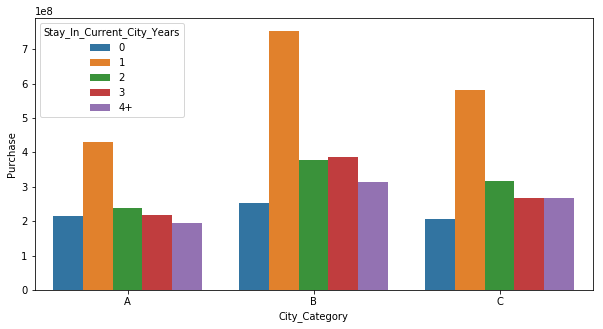

In [17]:
city_stay_total_purchase = df.groupby(['City_Category','Stay_In_Current_City_Years'])[['Purchase']].sum().reset_index()
figure = plt.figure(figsize=(10,5))
sns.barplot('City_Category','Purchase',hue='Stay_In_Current_City_Years',data=city_stay_total_purchase)

The above graph indicates customers have purchased more when they have stayed in the current city for 1 year. It's also safe to assume that customers tends to shop less if they are new to the city. The purchase amount has decresed as the stay in the city has gotten longer

Now let's plot purchases for the occupation,

In [18]:
occupation_total_purchase = df.groupby(['Occupation'])[['Purchase']].sum().reset_index()
occupation_total_purchase.head()

,Occupation,Purchase
0,0,625814811
1,1,414552829
2,2,233275393
3,3,160428450
4,4,657530393


In [19]:
occupation_purchase_count = df.groupby(['Occupation']).size().reset_index(name='counts')
occupation_purchase_count.head()

,Occupation,counts
0,0,68120
1,1,45971
2,2,25845
3,3,17366
4,4,70862


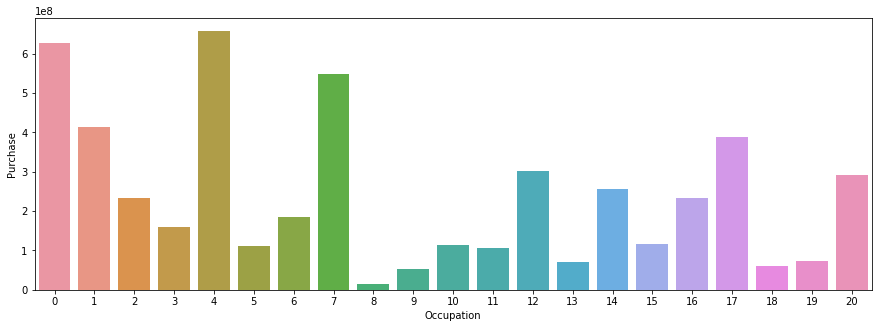

In [20]:
fig, axs = plt.subplots(figsize=(15,5))
sns.barplot(x = 'Occupation', y = 'Purchase', data = occupation_total_purchase)

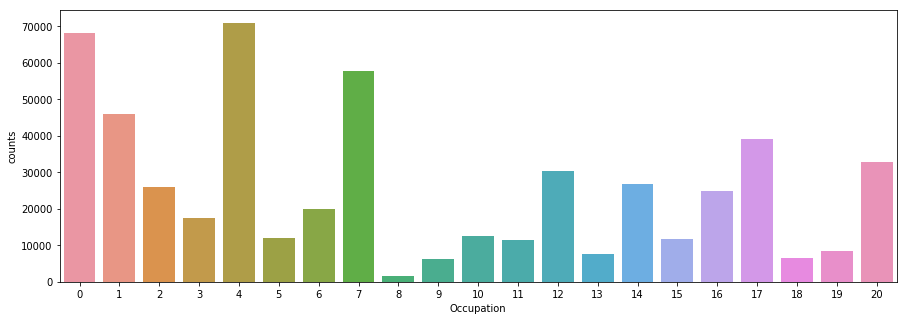

In [21]:
fig, axs = plt.subplots(figsize=(15,5))
sns.barplot(x = 'Occupation', y = 'counts', data = occupation_purchase_count)


As we can see for both the graphs occupation 4 and 0 have the highest total purchase amount and number of purchases. We see similar distribution for both the graphs.

In [22]:
df.groupby(['Product_ID', 'User_ID']).size().reset_index(name='counts')

,Product_ID,User_ID,counts
0,P00000142,1000001,1
1,P00000142,1000006,1
2,P00000142,1000018,1
3,P00000142,1000021,1
4,P00000142,1000023,1
5,P00000142,1000028,1
6,P00000142,1000034,1
7,P00000142,1000036,1
8,P00000142,1000048,1
9,P00000142,1000049,1


The dataset has one row for each distict User and Product combination.

(array([ 32175.,  57237., 130109., 104444.,  79179.,  24980.,  63928.,
         13437.,  29772.,   2316.]),
 array([  185. ,  2562.6,  4940.2,  7317.8,  9695.4, 12073. , 14450.6,
        16828.2, 19205.8, 21583.4, 23961. ]),
 <a list of 10 Patch objects>)

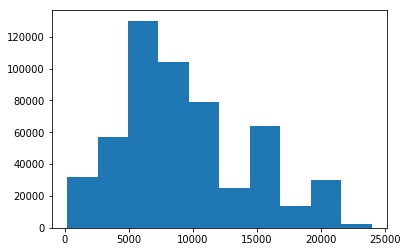

In [23]:
plt.hist(df['Purchase'], bins=10)

The above graph is more simmilar to Gaussian distribution. But it has peaks near 15000 and 20000. Also it seems to be right skewed. So Gaussian regression model might not be a good fit for this problem.

In [24]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.feature import RFormula
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.sql import SparkSession 
from pyspark.sql.functions import lit


In [25]:
spark = SparkSession.builder\
       .appName("donation_data")\
       .getOrCreate()
data = spark.read.format("csv").\
       option("header",True).\
       option("inferschema",True).\
       load(path)
test_data = spark.read.format("csv").\
       option("header",True).\
       option("inferschema",True).\
       load(test_path)


The test_data and train_data are in differnt files. To maintain data integrity both files are merged and passed through the same pipeline. As the test data doesn't contain the Purchase column, we add the Purchase column with value 0. After the data has been indexed and before training the models, the data is again split into train and test dataset based on the Purchase column value.

In [26]:
test_data = test_data.withColumn('Purchase',lit(0))
total_data=data.union(test_data)
total_data=total_data.na.fill(0)

As mentioned in the data analysis, only Product_Category_2 and Product_Category_3 have null values. As the values for Product_Category_1 are integer, lets fill the null values with 0.

In [27]:
formula = RFormula(
    formula="Purchase~.",
    featuresCol="features",
    labelCol="label")
output = formula.fit(total_data).transform(total_data)
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=22).fit(output)

train_data=output.filter("Purchase !=0")
test_data=output.filter("Purchase ==0")

The data analysis indicates that the data has a many features, and all the features seems to have weight in making the prediction. So the trees are used as predication model.

We have tuned the model with different values for maxDepth and maxBins. We initially gave more number of values for hyper parameters and found that below are the best values. In the below code we have taken out the all values other than the best ones, as the model takes longer to evaluate with multiple values.

In [28]:
dt_tvs = DecisionTreeRegressor(featuresCol='features')

paramGrid = ParamGridBuilder()\
    .addGrid(dt_tvs.maxDepth, [10]) \
    .addGrid(dt_tvs.maxBins, [100])\
    .build()

tvs = TrainValidationSplit(estimator=dt_tvs,\
                           estimatorParamMaps=paramGrid,\
                           evaluator=RegressionEvaluator(),\
                           trainRatio=0.8)

model_tvs = tvs.fit(train_data)

predictions = model_tvs.transform(test_data)
dt_tvs_pred=predictions.selectExpr('User_ID','Product_ID','prediction as Purchase')
dt_tvs_pred.show(25)
dt_tvs_pred.coalesce(1).write.format('csv').save(decision_tree_train_split_result,header = 'true')

+-------+----------+------------------+
|User_ID|Product_ID|          Purchase|
+-------+----------+------------------+
|1000004| P00128942|12965.747758193233|
|1000009| P00113442| 9926.387833147026|
|1000010| P00288442| 6107.128663246654|
|1000010| P00145342|  2640.91341991342|
|1000011| P00053842|2340.7246998284736|
|1000013| P00350442|11787.049796156087|
|1000013| P00155442|13856.125750192357|
|1000013|  P0094542|10510.851606674942|
|1000015| P00161842|12752.690476190477|
|1000022| P00067942| 6107.128663246654|
|1000026| P00046742|12965.747758193233|
|1000026| P00040042| 5966.838410171972|
|1000026| P00196542| 6396.049209207642|
|1000026| P00004542| 6396.049209207642|
|1000028| P00159542|18153.741414141416|
|1000029| P00111542|14947.181818181818|
|1000033| P00121042|13831.894409937888|
|1000033| P00344442| 6396.049209207642|
|1000034| P00265242|            8867.0|
|1000035|  P0096642|10510.851606674942|
|1000036| P00303042| 5966.838410171972|
|1000036| P00059642|12965.747758193233|


The RMSE score for Decision tree wih train validation split : 2941.77301982

We save the prediction data with 'User_ID','Product_ID','prediction as Purchase' columns in a csv file. And then upload it to analyticsvidhya website (please see the Read.me file) to get the RMSE score.

In [29]:
dt = DecisionTreeRegressor(featuresCol='features',maxDepth=10,maxBins=100)
pipeline = Pipeline(stages=[featureIndexer, dt])
crossval = CrossValidator(estimator=pipeline,
                          evaluator=RegressionEvaluator(),
                          estimatorParamMaps=paramGrid,
                          parallelism=3,
                          numFolds=4)
cvModel = crossval.fit(train_data)

predictions = cvModel.transform(test_data)
df_pred=predictions.selectExpr('User_ID','Product_ID','prediction as Purchase')
df_pred.show(25)
df_pred.coalesce(1).write.format('csv').save(decision_tree_result,header = 'true')

+-------+----------+------------------+
|User_ID|Product_ID|          Purchase|
+-------+----------+------------------+
|1000004| P00128942|12965.747758193233|
|1000009| P00113442| 9926.387833147026|
|1000010| P00288442| 6107.128663246654|
|1000010| P00145342|  2640.91341991342|
|1000011| P00053842|2340.7246998284736|
|1000013| P00350442|11787.049796156087|
|1000013| P00155442|13856.125750192357|
|1000013|  P0094542|10510.851606674942|
|1000015| P00161842|12752.690476190477|
|1000022| P00067942| 6107.128663246654|
|1000026| P00046742|12965.747758193233|
|1000026| P00040042| 5966.838410171972|
|1000026| P00196542| 6396.049209207642|
|1000026| P00004542| 6396.049209207642|
|1000028| P00159542|18153.741414141416|
|1000029| P00111542|14947.181818181818|
|1000033| P00121042|13831.894409937888|
|1000033| P00344442| 6396.049209207642|
|1000034| P00265242|            8867.0|
|1000035|  P0096642|10510.851606674942|
|1000036| P00303042| 5966.838410171972|
|1000036| P00059642|12965.747758193233|


The RMSE score for Decision tree wih Cross validation split:2941.7730198246

In [30]:
rf = RandomForestRegressor(featuresCol="indexedFeatures", numTrees=20)
pipeline_rf = Pipeline(stages=[featureIndexer, rf])
model_rf = pipeline_rf.fit(train_data)
predictions_rf = model_rf.transform(test_data)
df_pred_rf=predictions_rf.selectExpr('User_ID','Product_ID','prediction as Purchase')

predictions_rf = model_rf.transform(test_data)
df_pred_rf=predictions_rf.selectExpr('User_ID','Product_ID','prediction as Purchase')
df_pred_rf.show(25)
df_pred_rf.coalesce(1).write.format('csv').save(random_forest_result,header = 'true')


+-------+----------+------------------+
|User_ID|Product_ID|          Purchase|
+-------+----------+------------------+
|1000004| P00128942| 13359.84661871781|
|1000009| P00113442|10785.581837760265|
|1000010| P00288442| 6475.022790441633|
|1000010| P00145342| 3480.553198133098|
|1000011| P00053842|3513.5563234695314|
|1000013| P00350442|11470.044347208102|
|1000013| P00155442|13334.391861622571|
|1000013|  P0094542|10774.628649314636|
|1000015| P00161842|15244.477200973775|
|1000022| P00067942| 6475.022790441633|
|1000026| P00046742|13247.568771784263|
|1000026| P00040042| 6475.022790441633|
|1000026| P00196542|6644.2409457734175|
|1000026| P00004542| 6622.973360026108|
|1000028| P00159542|15514.500854352527|
|1000029| P00111542| 12925.31853011264|
|1000033| P00121042|13910.562470915833|
|1000033| P00344442|6644.2409457734175|
|1000034| P00265242| 6622.973360026108|
|1000035|  P0096642|11073.622735251676|
|1000036| P00303042| 6475.022790441633|
|1000036| P00059642|13839.655121217254|


The RMSE score for Random forest:3149.5798556.

We also trained DecisionTreeRegressor without the 'Stay in City column' with maxBins = 100 and maxDepth = 10. It gave the best regression score of 2939.5179. 

We tried Logistic regression and Linear regression which took too much memory. Also there are many features so we assume that the tress regressors would be a better fit for this problem. 

We have used decision trees and random forest regressions. We used Cross validation and Train Split with paramater grid for maxDepth and maxBin parameters to tune the decision tree. 

The decision tree with maxDepth = 10 and maxBin = 100 gives the best RMSE score 2940. 

We have also tried to fit the tree with lesser features which didn't give significantly better result.

For Random forest we tried the parameter numTrees = 10 and numTrees = 20. The RMSE score improved by very minimal points from 3151 to 3149. 

In conclusion the Decision tree model gave the best result and best improvement from 3282 to 2940, which is almost 10% improvement in the result.